In [90]:
import numpy as np
from kmodes.kmodes import KModes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

random.seed(5)


%matplotlib inline

In [91]:
df=pd.read_csv("data/report_anonymous_clean.csv", sep=";", encoding = 'utf8')

# drop cols 'Unnamed 0'
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [92]:
data = df[['ETA_PRELIEVO', 'CITO', 'BATT', 'MENOPAUSA']].copy()

data.dropna(inplace=True)
data = data.applymap(str)

km = KModes(n_clusters=10, init='Huang', n_init=5, verbose=0)

clusters = km.fit_predict(data)
print(km.cluster_centroids_)

[['35' 'NEGATIVO' 'VAGINOSI' 'False']
 ['38' 'NEGATIVO' 'COCCHI' 'False']
 ['45' 'NEGATIVO' 'DODERLEIN' 'False']
 ['33' 'NEGATIVO' 'DODERLEIN' 'False']
 ['28' 'NEGATIVO' 'CANDIDA' 'False']
 ['46' 'NEGATIVO' 'VAGINOSI' 'False']
 ['43' 'NEGATIVO' 'FLOGOSI' 'False']
 ['27' 'NEGATIVO' 'DODERLEIN' 'False']
 ['28' 'NEGATIVO' 'DODERLEIN' 'False']
 ['56' 'NEGATIVO' 'FLOGOSI' 'False']]


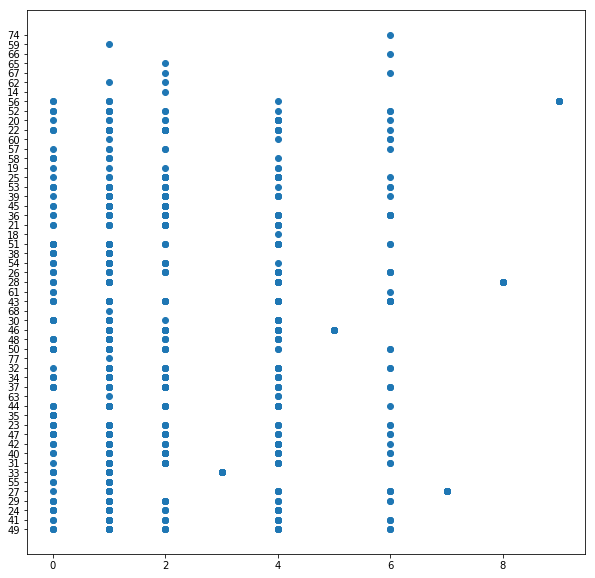

In [93]:
plt.figure(figsize=(10, 10))
plt.scatter(x=clusters, y=data['ETA_PRELIEVO'])
plt.show()

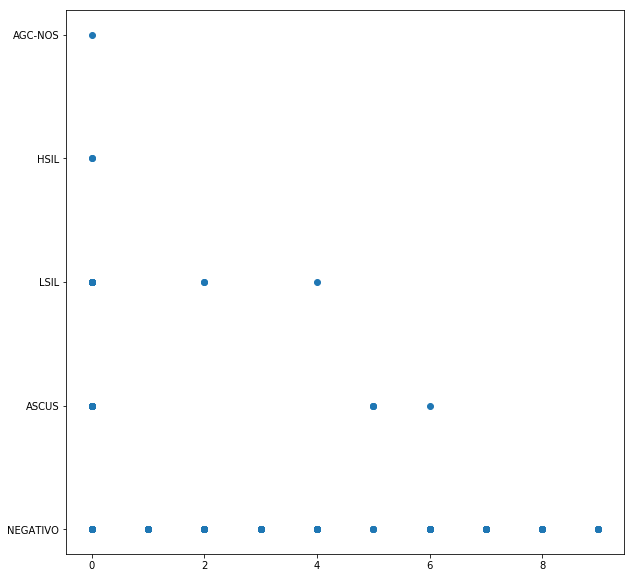

In [94]:
plt.figure(figsize=(10, 10))
plt.scatter(x=clusters, y=data['CITO'])
plt.show()